<a href="https://colab.research.google.com/github/se16wangmeiwei/RBPN/blob/main/rbpn_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


将外接py文件导入进来

In [73]:
import sys
sys.path.append('/content/drive/MyDrive/pyfile')

加载输入数据到网络的图片，包括 input, neigbor, flow

In [74]:
from PIL import Image
import numpy as np

调整图片尺寸

In [75]:
def rescale_img(img_in, scale):
    size_in = img_in.size
    new_size_in = tuple([int(x * scale) for x in size_in])
    img_in = img_in.resize(new_size_in, resample=Image.BICUBIC)
    return img_in

In [76]:
def modcrop(img, modulo):
    (ih, iw) = img.size
    ih = ih - (ih%modulo);
    iw = iw - (iw%modulo);
    img = img.crop((0, 0, ih, iw))
    return img

加载图片

In [77]:
def load_img_future(filepath, nFrames, scale, other_dataset):
  tt = int(nFrames/2)
  if other_dataset:
    target = modcrop(Image.open(filepath).convert('RGB'),scale)
    input = target.resize((int(target.size[0]/scale),int(target.size[1]/scale)), Image.BICUBIC)
    
    char_len = len(filepath)
    neigbor=[]
    if nFrames%2 == 0:
      seq = [x for x in range(-tt,tt) if x!=0] # or seq = [x for x in range(-tt+1,tt+1) if x!=0]
    else:
      seq = [x for x in range(-tt,tt+1) if x!=0]
    #random.shuffle(seq) #if random sequence
    print("seq")
    print(seq)
    for i in seq:
      index1 = int(filepath[char_len-7:char_len-4])+i
      file_name1=filepath[0:char_len-7]+'{0:03d}'.format(index1)+'.png'
      print(file_name1)
      if os.path.exists(file_name1):
          temp = modcrop(Image.open(file_name1).convert('RGB'), scale).resize((int(target.size[0]/scale),int(target.size[1]/scale)), Image.BICUBIC)
          neigbor.append(temp)
      else:
          print('neigbor frame- is not exist')
          temp=input
          neigbor.append(temp)
      
  else:
    target = modcrop(Image.open(join(filepath,'im4.png')).convert('RGB'),scale)
    input = target.resize((int(target.size[0]/scale),int(target.size[1]/scale)), Image.BICUBIC)
    neigbor = []
    seq = [x for x in range(4-tt,5+tt) if x!=4]
    #random.shuffle(seq) #if random sequence
    for j in seq:
        neigbor.append(modcrop(Image.open(filepath+'/im'+str(j)+'.png').convert('RGB'), scale).resize((int(target.size[0]/scale),int(target.size[1]/scale)), Image.BICUBIC))
  return target, input, neigbor

In [78]:
from os.path import join
image_dir="/content/drive/MyDrive/data/Vid4"
file_list="foliage.txt"

alist = [line.rstrip() for line in open(join(image_dir,file_list))]
image_filenames = [join(image_dir,x) for x in alist]
print(image_filenames)
print(alist)

['/content/drive/MyDrive/data/Vid4/foliage/001.png', '/content/drive/MyDrive/data/Vid4/foliage/002.png', '/content/drive/MyDrive/data/Vid4/foliage/003.png', '/content/drive/MyDrive/data/Vid4/foliage/004.png', '/content/drive/MyDrive/data/Vid4/foliage/005.png', '/content/drive/MyDrive/data/Vid4/foliage/006.png', '/content/drive/MyDrive/data/Vid4/foliage/007.png', '/content/drive/MyDrive/data/Vid4/foliage/008.png', '/content/drive/MyDrive/data/Vid4/foliage/009.png', '/content/drive/MyDrive/data/Vid4/foliage/010.png', '/content/drive/MyDrive/data/Vid4/foliage/011.png', '/content/drive/MyDrive/data/Vid4/foliage/012.png', '/content/drive/MyDrive/data/Vid4/foliage/013.png', '/content/drive/MyDrive/data/Vid4/foliage/014.png', '/content/drive/MyDrive/data/Vid4/foliage/015.png', '/content/drive/MyDrive/data/Vid4/foliage/016.png', '/content/drive/MyDrive/data/Vid4/foliage/017.png', '/content/drive/MyDrive/data/Vid4/foliage/018.png', '/content/drive/MyDrive/data/Vid4/foliage/019.png', '/content/d

In [79]:
target, input, neigbor = load_img_future(image_filenames[4],7,4,True)
inputs = input
targets = target

seq
[-3, -2, -1, 1, 2, 3]
/content/drive/MyDrive/data/Vid4/foliage/002.png
/content/drive/MyDrive/data/Vid4/foliage/003.png
/content/drive/MyDrive/data/Vid4/foliage/004.png
/content/drive/MyDrive/data/Vid4/foliage/006.png
/content/drive/MyDrive/data/Vid4/foliage/007.png
/content/drive/MyDrive/data/Vid4/foliage/008.png
neigbor frame- is not exist


In [80]:
def get_flow(im1, im2):
    im1 = np.array(im1)
    im2 = np.array(im2)
    im1 = im1.astype(float) / 255.
    im2 = im2.astype(float) / 255.
    
    # Flow Options:
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 30
    colType = 0  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))
    
    u, v, im2W = pyflow.coarse2fine_flow(im1, im2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,nSORIterations, colType)
    flow = np.concatenate((u[..., None], v[..., None]), axis=2)
    #flow = rescale_flow(flow,0,1)
    return flow

In [81]:
import pyflow
flow = [get_flow(input,j) for j in neigbor]


转换为tensor变量

In [82]:
import torchvision.transforms as transforms
import torch

bicubic = rescale_img(input, 4)

transform = transforms.ToTensor()
# target = transform(target)
input = transform(input)
bicubic = transform(bicubic)
neigbor = [transform(j) for j in neigbor]
flow = [torch.from_numpy(j.transpose(2,0,1)) for j in flow]


In [83]:
input = input.reshape(1,3,30, 45)
neigbor = [j.reshape(1,3,30, 45) for j in neigbor]
flow = [j.reshape(1,2,30, 45) for j in flow]

input = input.type(torch.FloatTensor)
neigbor = [j.type(torch.FloatTensor) for j in neigbor]
flow = [j.type(torch.FloatTensor) for j in flow]


加载RBPN模型

In [ ]:
from __future__ import print_function
import argparse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from rbpn import Net as RBPN
from data import get_test_set
from functools import reduce
import numpy as np

# from scipy.misc import imsave
import scipy.io as sio
import time
import cv2
import math
import pdb

# Training settings
parser = argparse.ArgumentParser(description='PyTorch Super Res Example')
parser.add_argument('--upscale_factor', type=int, default=4, help="super resolution upscale factor")
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--gpu_mode', type=bool, default=True)
parser.add_argument('--chop_forward', type=bool, default=False)
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--gpus', default=1, type=int, help='number of gpu')
parser.add_argument('--data_dir', type=str, default='/content/drive/MyDrive/data/Vid4')
parser.add_argument('--file_list', type=str, default='/content/drive/MyDrive/data/Vid4/foliage.txt')
parser.add_argument('--other_dataset', type=bool, default=True, help="use other dataset than vimeo-90k")
parser.add_argument('--future_frame', type=bool, default=True, help="use future frame")
parser.add_argument('--nFrames', type=int, default=7)
parser.add_argument('--model_type', type=str, default='RBPN')
parser.add_argument('--residual', type=bool, default=False)
parser.add_argument('--output', default='/content/Results/', help='Location to save checkpoint models')
parser.add_argument('--model', default='/content/drive/MyDrive/pyfile/RBPN_4x.pth', help='sr pretrained base model')

opt = parser.parse_args(args=[])

gpus_list=range(opt.gpus)
print(opt)

cuda = opt.gpu_mode
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)

# print('===> Loading datasets')
# test_set = get_test_set(opt.data_dir, opt.nFrames, opt.upscale_factor, opt.file_list, opt.other_dataset, opt.future_frame)
# testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

print('===> Building model ', opt.model_type)
if opt.model_type == 'RBPN':
    model = RBPN(num_channels=3, base_filter=256,  feat = 64, num_stages=3, n_resblock=5, nFrames=opt.nFrames, scale_factor=opt.upscale_factor)
    print(model)

if cuda:
    model = torch.nn.DataParallel(model, device_ids=gpus_list)

model.load_state_dict(torch.load(opt.model, map_location=lambda storage, loc: storage))
print('Pre-trained SR model is loaded.')

if cuda:
    model = model.cuda(gpus_list[0])


In [85]:
paramater = torch.load('/content/drive/MyDrive/pyfile/RBPN_4x.pth')

In [86]:
# model.eval()
with torch.no_grad():
  prediction = model(input, neigbor, flow)

torch.Size([1, 384, 120, 180])




In [87]:
image = prediction

In [88]:
unloader = transforms.ToPILImage()
# image = original_tensor.gpu().clone()  # clone the tensor
image = image.squeeze(0)  # remove the fake batch dimension
image = unloader(image)
# image.save('example.jpg')

In [89]:
inputs=rescale_img(inputs,4)

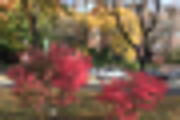

In [90]:
inputs

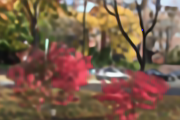

In [91]:
image

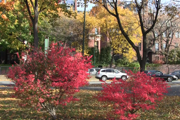

In [92]:
targets

In [93]:
targets = transform(targets)
inputs = transform(inputs)
image = transform(image)

将输入图片、输出图片、GT放在同一个grid中显示

In [94]:
# inputs.shape
listimage = []

In [95]:
listimage.append(inputs)
listimage.append(image)
listimage.append(targets)

In [96]:
type(listimage)

list

input & output&groundtruth


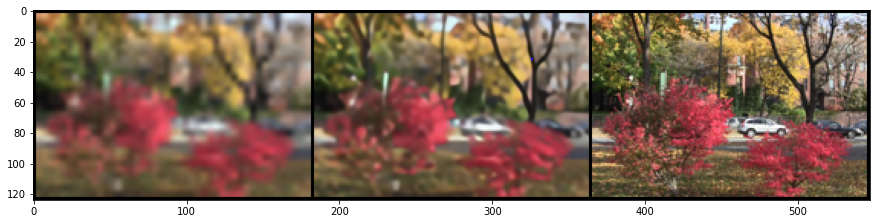

In [97]:
import torchvision
import matplotlib.pyplot as plt
grid = torchvision.utils.make_grid(listimage, nrow=3)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print('input '+'& output'+'&groundtruth')
